#  Cell State Transition Analysis with scMagnify 

## Preliminaries

scMagnify is a versatile Python toolkit for inferring and analyzing gene regulatory networks (GRNs) from single-cell multi-omic datasets.

In this tutorial, you will learn how to:

- **Fate Mapping.** Use `cellrank` {cite}`Lange_2022,Weiler_2024` to infer fate probabilities and construct a transition matrix of cellular dynamics.
- **Cell State Selection.** Perform lineage classifer or paga graph operator to select cell state you are interested in.
- **Feature Association Test.** Annotate significantly changing feature along pseudotime test.

:::{note}

This tutorial aims to assist users in preprocessing the scRNAseq data for scMagnify analysis. `cellrank` is a unified fate-mapping framework designed for studying cellular dynamics through Markov state modeling of multi-view single-cell data. For detailed instructions on the usage of [cellrank](https://cellrank.readthedocs.io/en/latest/), please refer to the official tutorial.


And this tutorial does not cover the preprocessing of scRNA-seq data, nor the computation of pseudotime or RNA velocity. Please refer to the relevant documentation for those topics:

- [scanpy](https://scanpy.readthedocs.io/en/stable/){cite}`Wolf_2018` for basic single-cell data analysis.
- [palantir](https://palantir.readthedocs.io/en/latest/){cite}`Setty_2019` for pseudotime analysis.
- [scvelo](https://scvelo.readthedocs.io/en/stable/){cite}`Bergen_2020` for RNA velocity analysis.

:::

## Import packages

In [ ]:
%load_ext autoreload
%autoreload 2

In [47]:
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [48]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
import scanpy as sc
import cellrank as cr

In [50]:
import scmagnify as scm
import scmagnify.logging as logg
from scmagnify.settings import settings


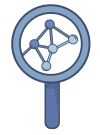

In [51]:
scm.info()

## Configurations

Before starting the analysis, we need to configure our environment. This primarily involves four steps: 

1. Downloading built-in data
2. Initializing plot settings
3. Setting a workspace 
4. Specifying a reference genome

First, if you are using `scMagnify` for the first time, please run the following command to fetch the required annotations. This only needs to be performed once.


In [7]:
scm.settings.verbosity = 2

In [8]:
os.environ["SCMAGNIFY_DATA"] = "/mnt/TrueNas/project/chenxufeng/Caches/scmagnify/"

In [14]:
scm.datasets.fetch_scm_data()

Unzipping contents of '/mnt/TrueNas/project/chenxufeng/Caches/scmagnify/scmagnify_data.zip' to '/mnt/TrueNas/project/chenxufeng/Caches/scmagnify/scmagnify_data.zip.unzip'


INFO     Moving from '/mnt/TrueNas/project/chenxufeng/Caches/scmagnify/scmagnify_data.zip.unzip/data' to           
         '/mnt/TrueNas/project/chenxufeng/Caches/scmagnify/scm_data'...

INFO     Cleaned up temporary directory: /mnt/TrueNas/project/chenxufeng/Caches/scmagnify/scmagnify_data.zip.unzip

INFO     Could not clean up temporary directory                                                                    
         /mnt/TrueNas/project/chenxufeng/Caches/scmagnify/scmagnify_data.zip.unzip: [Errno 20] Not a directory:    
         '/mnt/TrueNas/project/chenxufeng/Caches/scmagnify/scmagnify_data.zip'

'/mnt/TrueNas/project/chenxufeng/Caches/scmagnify/scm_data'

:::{note} `scMagnify` uses `pooch` to manage built-in datasets. By default, all data is cached in the `./caches/scmagnify/`. If you wish to change this location, you can set the `SCMAGNIFY_DATA` environment variable.

For more details on data management, please see [Advanced Usages/Configurations](./Advanced Usages/Configurations.md) and the official [pooch](https://www.fatiando.org/pooch/latest/) documentation. :::


Now, let's proceed with the other configuration steps.

In [15]:
%matplotlib inline

scm.settings.set_figure_params(
    dpi=100,
    facecolor="white",
    frameon=False,
) 

# Load fonts from scm_data
scm.load_fonts(["Arial"])

plt.rcParams["font.family"] = "Arial"
plt.rcParams['grid.alpha'] = 0
plt.rcParams['savefig.dpi'] = 300

In [16]:
# Setting a workspace
dirPjtHome = "/mnt/TrueNas/project/chenxufeng/Data/PMID36973557_NatBiotechnol2023_T-cell-depleted/"
workDir = os.path.join(dirPjtHome, "scmagnify_wd")
scm.set_workspace(workDir)

workspace: /mnt/TrueNas/project/chenxufeng/Data/PMID36973557_NatBiotechnol2023_T-cell-depleted/scmagnify_wd/
├── data
├── models
├── tmpfiles
└── figures

In [17]:
# Set up Reference Genome
scm.set_genome(
    version="hg38",
    genomes_dir="/home/chenxufeng/picb_cxf/Ref/human/hg38/"
)

                        Genome Information                        
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Version ┃ Provider ┃ Directory                                 ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hg38    │ UCSC     │ /home/chenxufeng/picb_cxf/Ref/human/hg38/ │
└─────────┴──────────┴───────────────────────────────────────────┘

:::{note} scMagnify utilizes `genompy`{cite}`` for managing reference genome files. genompy simplifies the process of searching, downloading, and preprocessing genomes and annotations from providers like UCSC, Ensembl, and GENCODE.

For more details on managing genome files, please see [Advanced Usages/Configurations](./Advanced Usages/Configurations.md) and the official genompy documentation. :::

## Load the data

To demonstrate the approach in this tutorial, we will use a human blood dataset containing single-cell multi-omic data of CD34+ bone marrow cells from healthy donors, which can be conveniently acessed through {mod}`~scmagnify.datasets.human_tcelldep_bm` {cite}.

Since we have already configured a workspace, the dataset will be automatically downloaded and stored in `scm.settings.data_dir`.

In [13]:
mdata = scm.datasets.human_tcelldep_bm()

In [18]:
mdata = scm.read(os.path.join(settings.data_dir, "mdata_tcelldep-bm_raw.h5mu"))

In [19]:
mdata

MuData object with n_obs × n_vars = 8627 × 233703
  2 modalities
    ATAC:	8627 x 216477
      obs:	'sample', 'celltype', 'TSSEnrichment', 'NucleosomeRatio', 'nFrags', 'BlacklistRatio'
      var:	'seqnames', 'start', 'end', 'strand', 'GC', 'Bcells_primed', 'Bcells_lineage_specific'
      uns:	'celltype_colors', 'neighbors', 'sample_colors', 'umap'
      obsm:	'DM_EigenVectors', 'GeneScores', 'X_svd', 'X_umap'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    RNA:	8627 x 17226
      obs:	'sample', 'celltype', 'palantir_pseudotime'
      var:	'highly_variable'
      uns:	'celltype_colors', 'neighbors', 'sample_colors', 'umap'
      obsm:	'X_FDL', 'X_pca', 'X_umap'
      layers:	'MAGIC_imputed_data', 'counts'
      obsp:	'connectivities', 'distances', 'knn'

In [20]:
adata = mdata["RNA"]

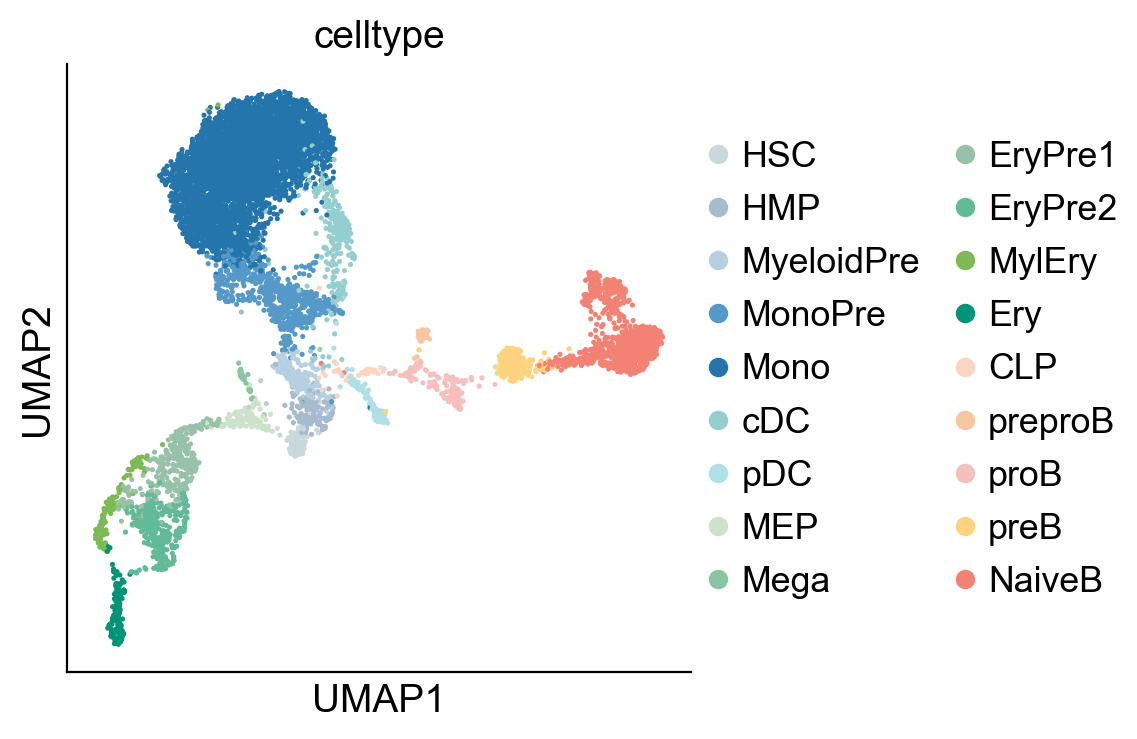

In [21]:
sc.pl.umap(adata, color=["celltype"])

## Fate mapping with CellRank

In [22]:
pk = cr.kernels.PseudotimeKernel(adata, time_key="palantir_pseudotime")
pk.compute_transition_matrix()

  0%|          | 0/8627 [00:00<?, ?cell/s]

PseudotimeKernel[n=8627, dnorm=False, scheme='hard', frac_to_keep=0.3]

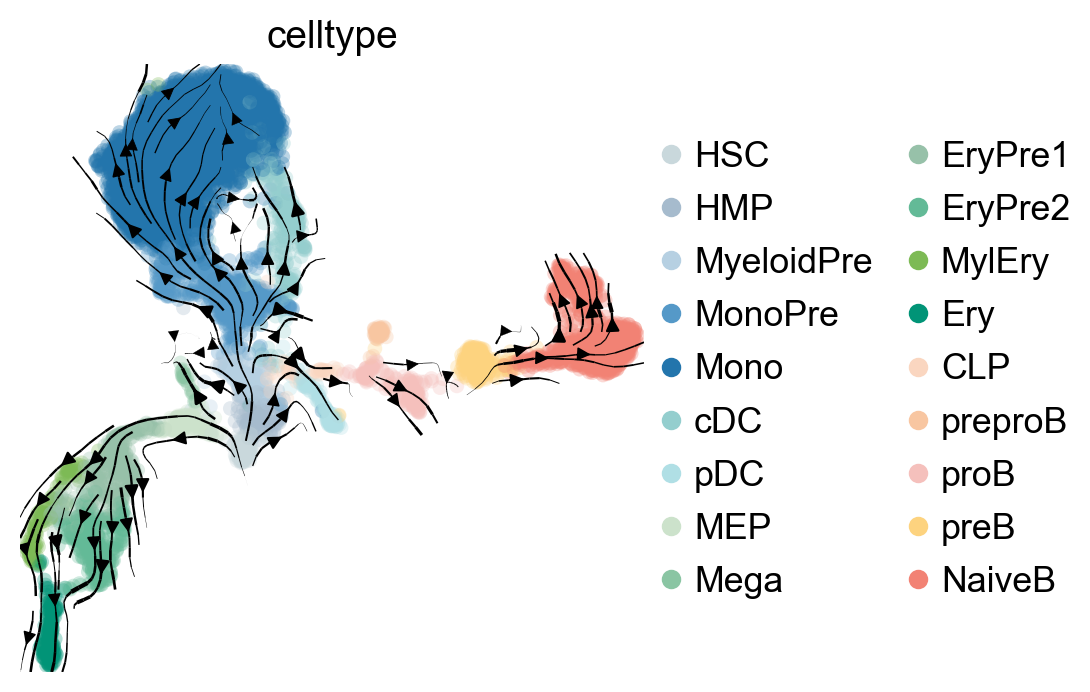

In [23]:
pk.plot_projection(basis="umap", 
                   recompute=True, 
                   color='celltype', 
                   legend_loc="right")

2025-10-28 06:50:10 | [INFO] Using pre-computed Schur decomposition


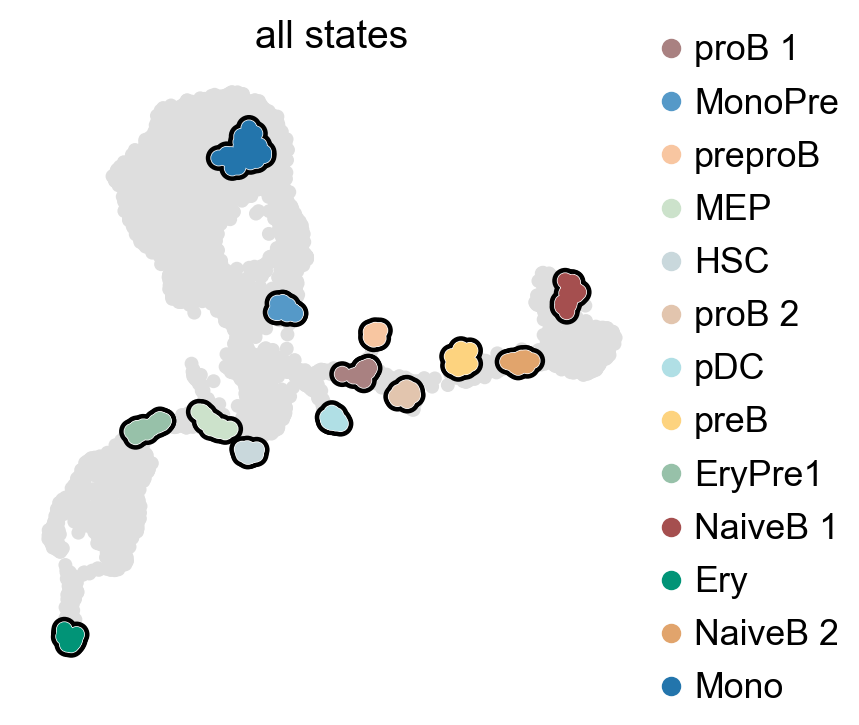

In [24]:
g = cr.estimators.GPCCA(pk)
g.compute_macrostates(n_states=13, cluster_key="celltype")
g.plot_macrostates(which="all", 
                   discrete=True, 
                   legend_loc="right", 
                   s=100)

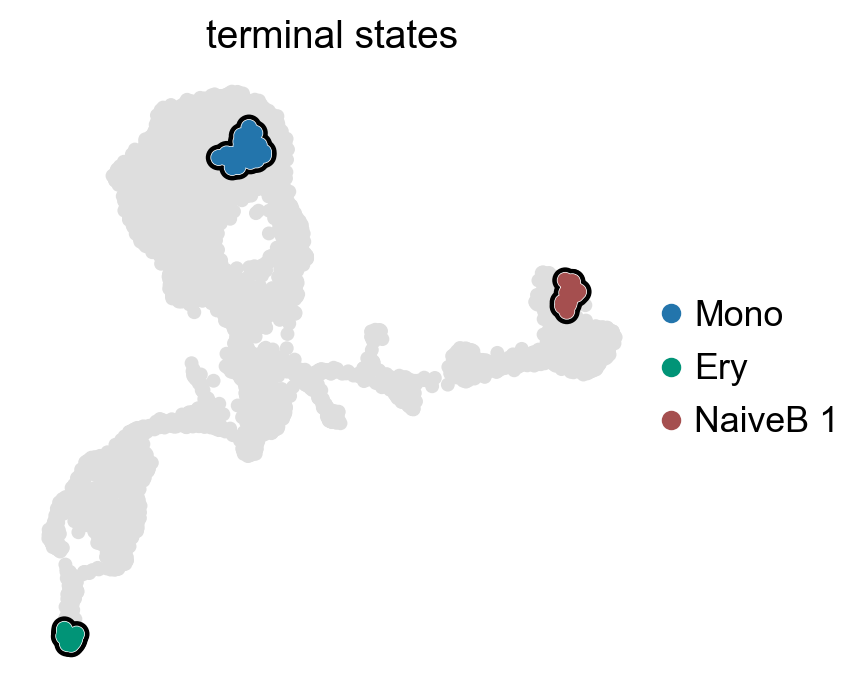

In [25]:
g.set_terminal_states(states=['Mono', 'Ery', 'NaiveB_1'])
g.plot_macrostates(which="terminal", legend_loc="right", s=100)

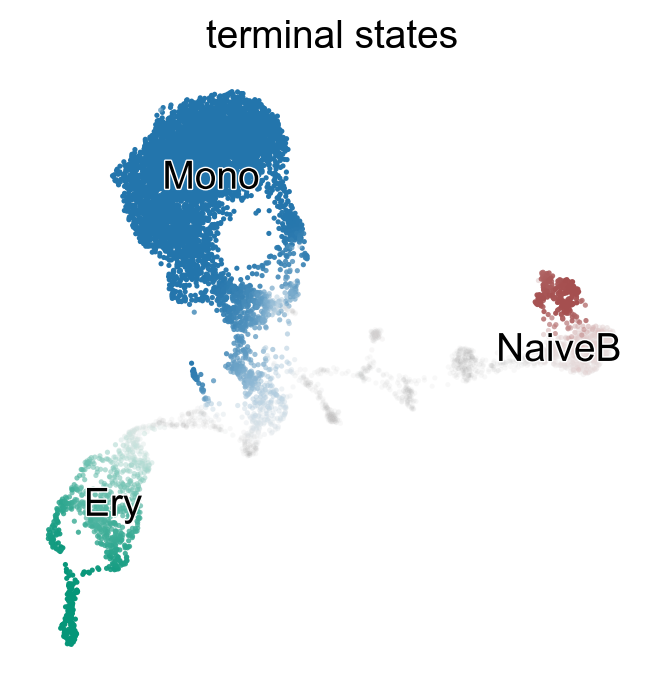

In [26]:
g.rename_terminal_states({'NaiveB_1':'NaiveB'})
g.plot_macrostates(which="terminal", discrete=False)

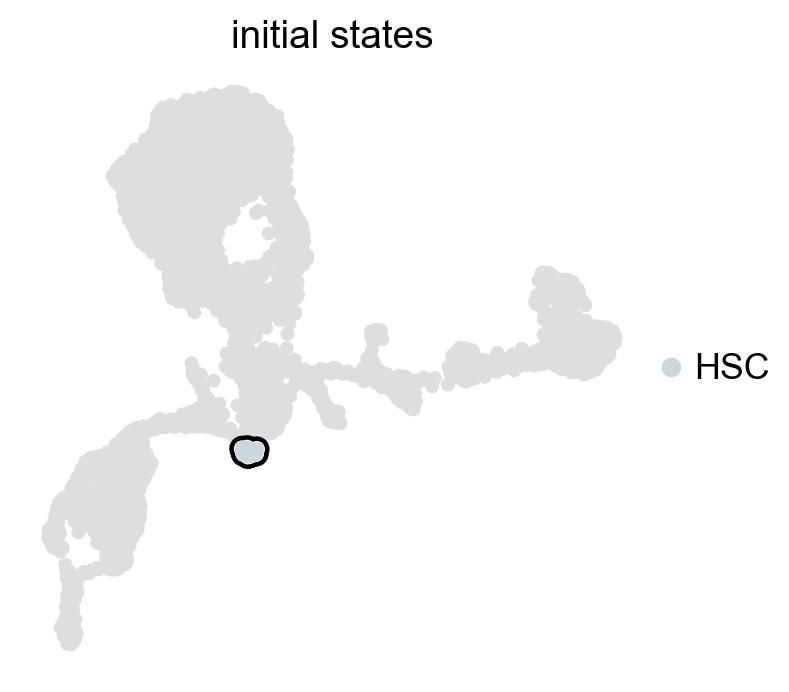

In [27]:
g.set_initial_states(states=['HSC'])
g.plot_macrostates(which="initial", legend_loc="right", s=100)

  0%|          | 0/3 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


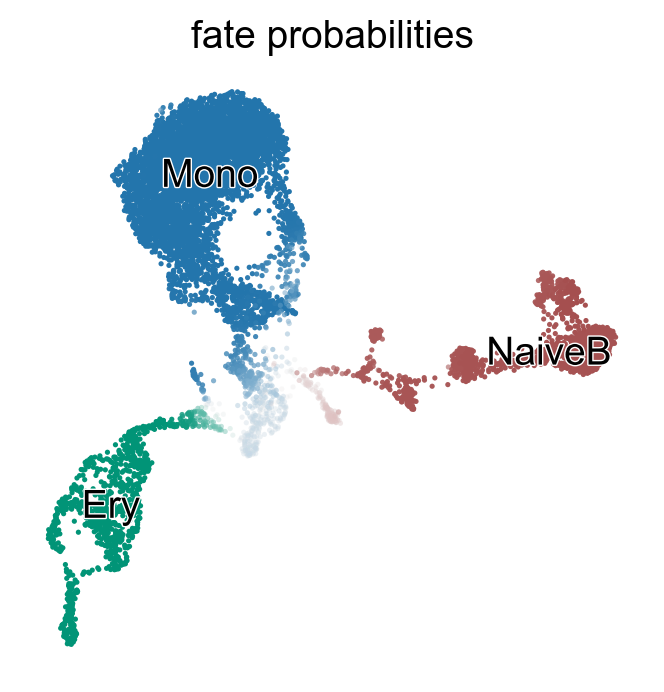

In [28]:
g.compute_fate_probabilities()
g.plot_fate_probabilities(same_plot=True)

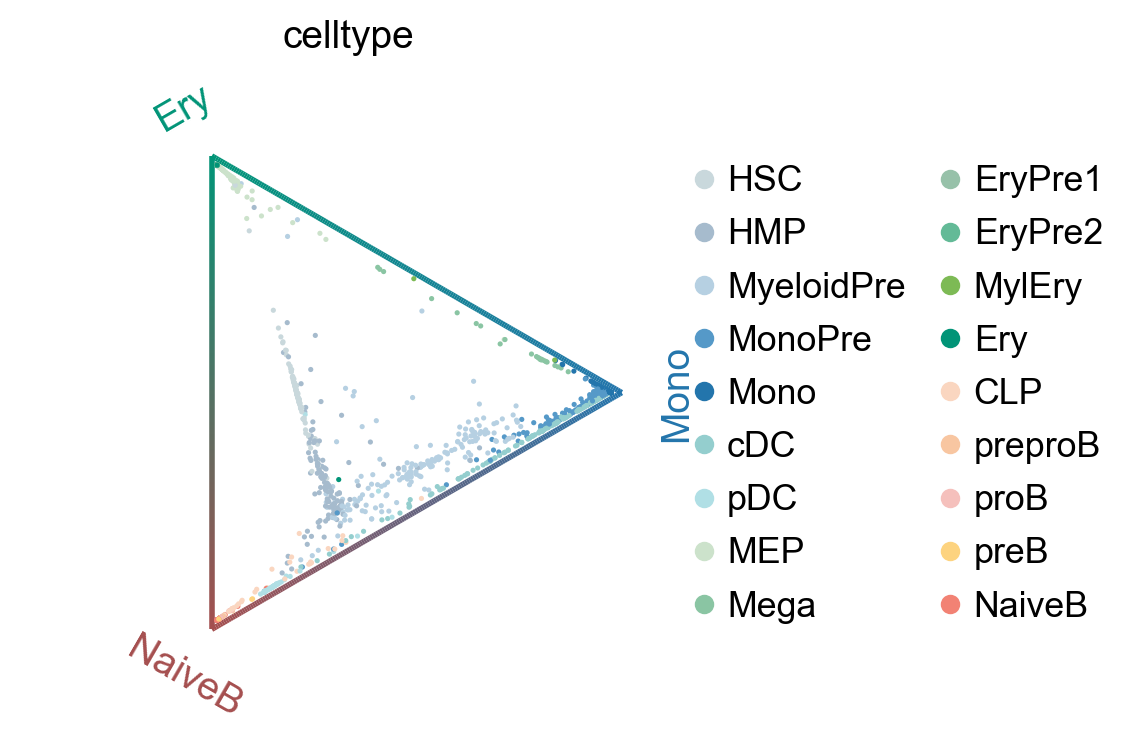

In [29]:
cr.pl.circular_projection(adata, keys=["celltype"], legend_loc="right")

In [30]:
adata.obsm['cellrank_fate_probabilities'] = pd.DataFrame(g.fate_probabilities, 
                                                         index=adata.obs_names, 
                                                         columns=g.terminal_states.cat.categories)

## Selecting by Lineage Classifer

Now that we have stored the `cellrank_fate_probabilities` in `adata.obsm`, we can use these probabilities to formally classify cells into their most likely lineage. This provides a clear-cut assignment for selecting cells belonging to a specific fate.

In [31]:
mdata = scm.tl.lineage_classifer(mdata)

INFO     .obsm['cell_state_masks'] --> added

       Cell State Statistics        
┏━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Cell State ┃ Number ┃ Percentage ┃
┡━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│    Mono    │  5556  │   64.40%   │
│    Ery     │  993   │   11.51%   │
│   NaiveB   │  1379  │   15.98%   │
└────────────┴────────┴────────────┘

INFO     Saved masks in                                                                                            
         /mnt/TrueNas/project/chenxufeng/Data/PMID36973557_NatBiotechnol2023_T-cell-depleted/scmagnify_wd/tmpfiles/
         cell_state_masks.csv

:::{warning}

You should manually remove cell types from the lineage that contradict established biological knowledge.

:::

In [32]:
for lineage in adata.obsm['cell_state_masks'].columns:
    print(adata[adata.obsm['cell_state_masks'][lineage]].obs.celltype.value_counts())

celltype
Mono          4659
MonoPre        607
cDC            131
MyeloidPre      88
HSC             38
HMP             32
pDC              1
Name: count, dtype: int64
celltype
EryPre2    326
EryPre1    315
Ery        156
MylEry     120
MEP         60
HSC         16
Name: count, dtype: int64
celltype
NaiveB        876
preB          214
proB          155
preproB        59
HSC            25
CLP            23
HMP            22
MyeloidPre      4
pDC             1
Name: count, dtype: int64


In [33]:
del_celltype = {
    'Mono': ['cDC', 'pDC'],
    'Ery': [],
    'NaiveB': ['MyeloidPre', 'pDC']
}

In [34]:
for lineage in adata.obsm['cell_state_masks'].columns:
    criteria = (adata.obsm['cell_state_masks'][lineage]) & (adata.obs.celltype.isin(del_celltype[lineage]))
    index = adata[criteria].obsm['cell_state_masks'][lineage].index
    df = adata.obsm['cell_state_masks'].copy()
    df.loc[index, lineage] = False
    adata.obsm['cell_state_masks'] = df

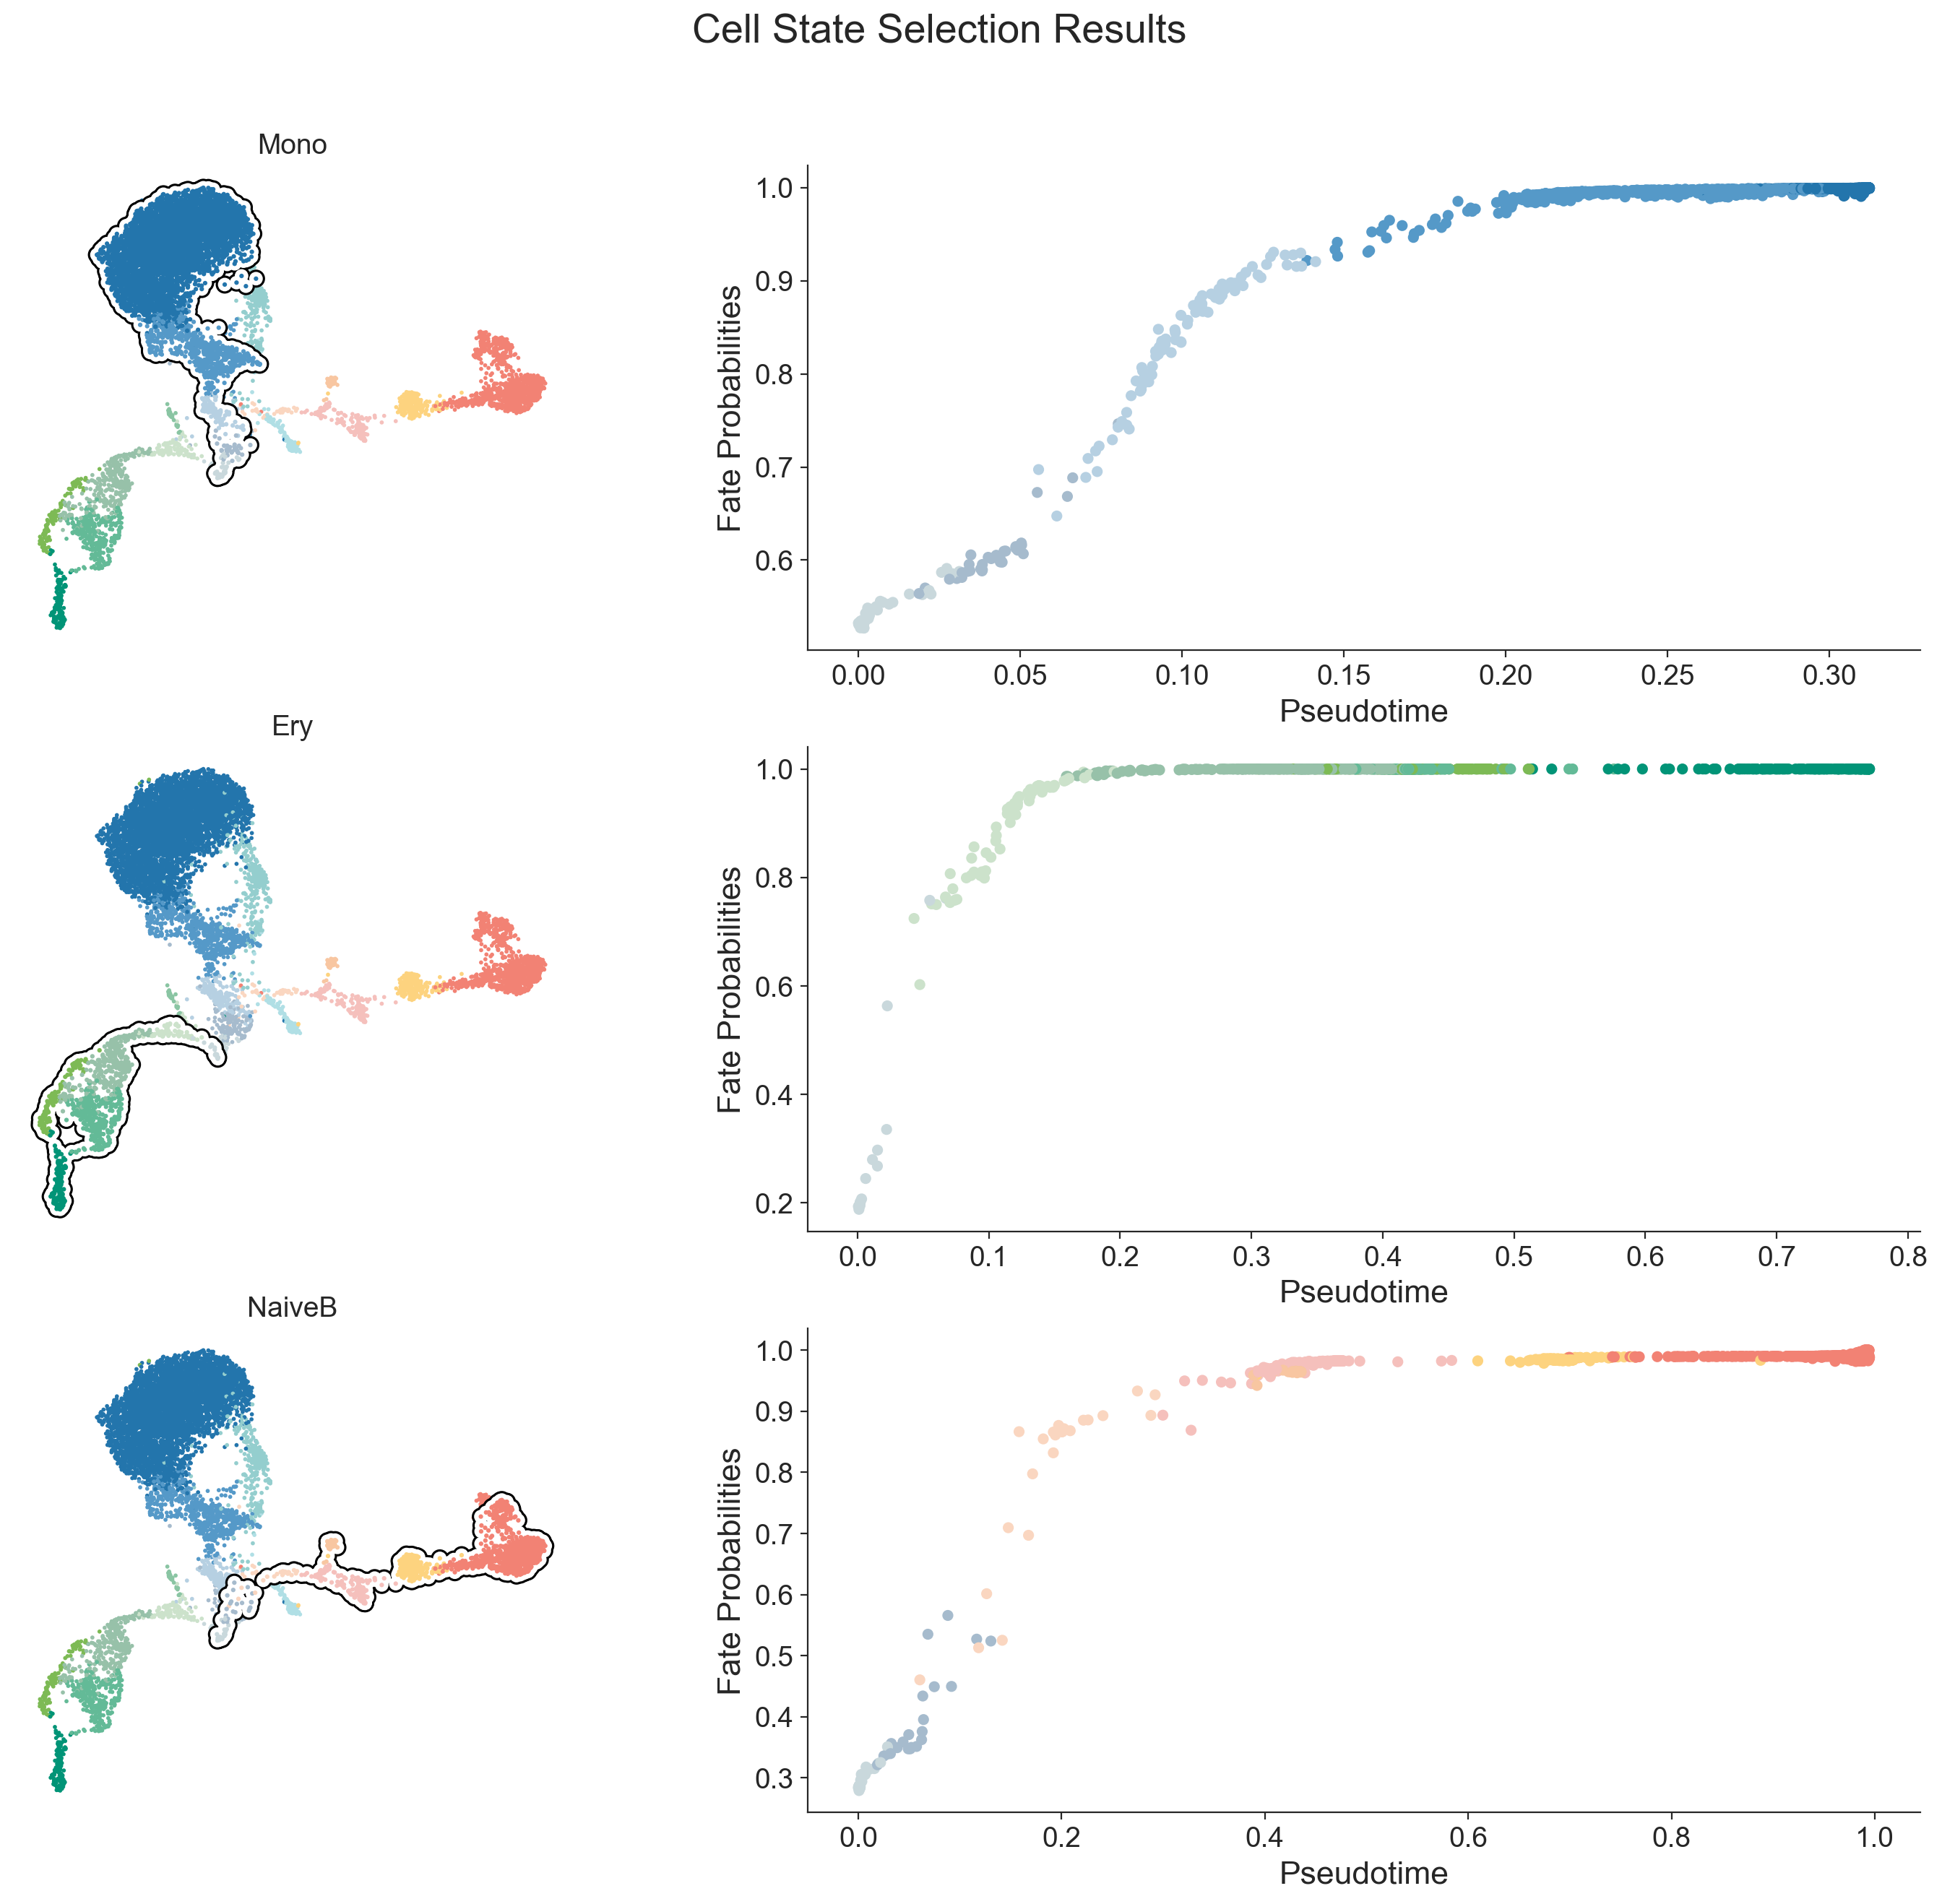

In [35]:
scm.pl.cell_state_select(mdata, mask_key="cell_state_masks")

In [36]:
mdata.update()

## Feature Association Test

To identify genes that change significantly along pseudotime, we fit [Generalized Additive Models](https://en.wikipedia.org/wiki/Generalized_additive_model) (GAMs) on normalized counts using gaussian errors {cite}`Faure_2023`.

This approach is inspired by `scFates`, but other awesome methods for differential expression along pseudotime, such as `PseudotimeDE` {cite}`Song_2021` or `Lamian` {cite}`Hou_2023`, can also be applied.


In [37]:
mdata["RNA"].X = mdata["RNA"].layers["counts"].copy()
sc.pp.normalize_total(mdata["RNA"], target_sum=1e4)
sc.pp.log1p(mdata["RNA"])
mdata["RNA"].layers["log1p_norm"] = mdata["RNA"].X.copy() 

We first run the association test on the `log1p_norm` layer. `n_splines` controls the GAM curve flexibility (see [pyGAM](https://pygam.readthedocs.io/en/latest/) documentation).

In [38]:
mdata = scm.tl.test_association(
    mdata,                             
    modal="RNA",
    layer="log1p_norm", 
    A_cutoff=0.5,
    fdr_cutoff=1e-3,
    n_splines=5,
    n_jobs=10,
    recompute=True
)

INFO     Running association test...

INFO     Testing association between log1p_norm gene expression and palantir_pseudotime...

Output()

INFO     .varm['test_assoc_res'] --> added                                                                         
         .uns['test_assoc'] --> added

          Feature Association Statistics           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃                   Metric ┃ Value                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│              Total Genes │ 17,226               │
│               Thresholds │ FDR < 0.001, A > 0.5 │
│ Significant genes (n, %) │ 1,810 (10.51%)       │
└──────────────────────────┴──────────────────────┘

To efficiently test new thresholds, we simply call the function again. Since `recompute` defaults to `False`, this instantly updates the significant gene set using the new cutoffs without re-fitting models.

In [39]:
# Change cutoffs 
mdata = scm.tl.test_association(
    mdata,                             
    A_cutoff=0.3,
    fdr_cutoff=1e-3,
)

INFO     Using existing association test results.

          Feature Association Statistics           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃                   Metric ┃ Value                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│              Total Genes │ 17,226               │
│               Thresholds │ FDR < 0.001, A > 0.3 │
│ Significant genes (n, %) │ 3,281 (19.05%)       │
└──────────────────────────┴──────────────────────┘

With the association test computed, let's visualize the results for all genes, and let's highlight a pre-defined set of key transcription factors using `scm.pl.test_association()`.

In [40]:
key_TFs= ["PAX5", "EBF1", "TCF3", "IKZF1", "POU2F2", "FOXO1", "IRF4", "SOX4"]

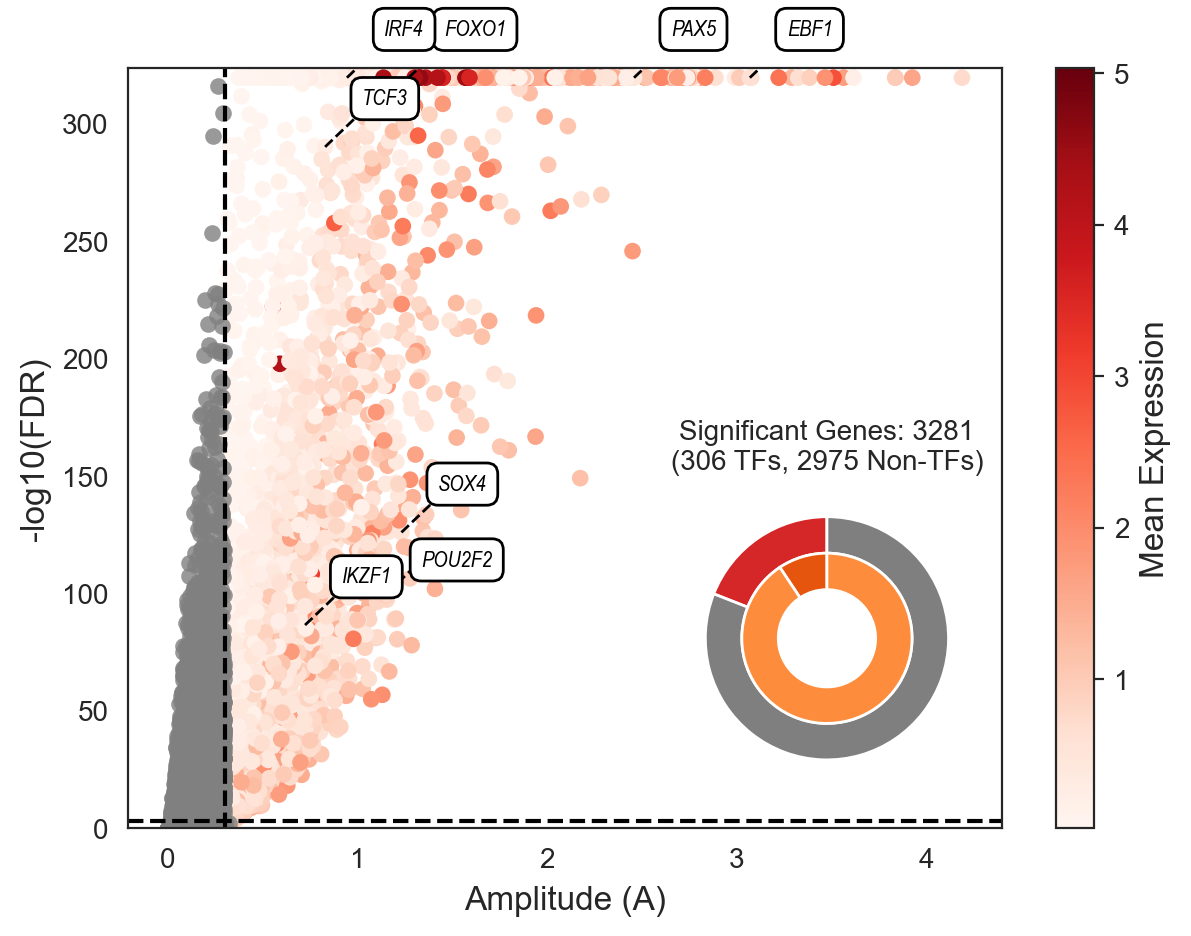

In [41]:
scm.pl.test_association(
    mdata, 
    A_cutoff=0.3,
    fdr_cutoff=1e-3,
    selected_genes=key_TFs
)

In the plot above, each dot represents a gene. The x-axis shows the `amplitude (A)` of its expression change along the trajectory, while the y-axis represents the `statistical significance (-log10 FDR)`. Genes are colored by their `mean expression`.

We have highlighted several `key_TFs` known to be crucial for this B-cell differentiation process. The specific functions and literature references supporting the roles of these TFs are detailed in **Supplementary Table 2** of the [manuscript]().

## Visualize the Gene Expression Dynamics

After identifying significant genes and classifying cells, we can visualize their expression dynamics along the inferred differentiation trajectory.

First, let's plot a heatmap of all significant genes for the 'NaiveB' lineage, sorted by `palantir_pseudotime`. This gives a global overview of gene expression trends.

did not converge


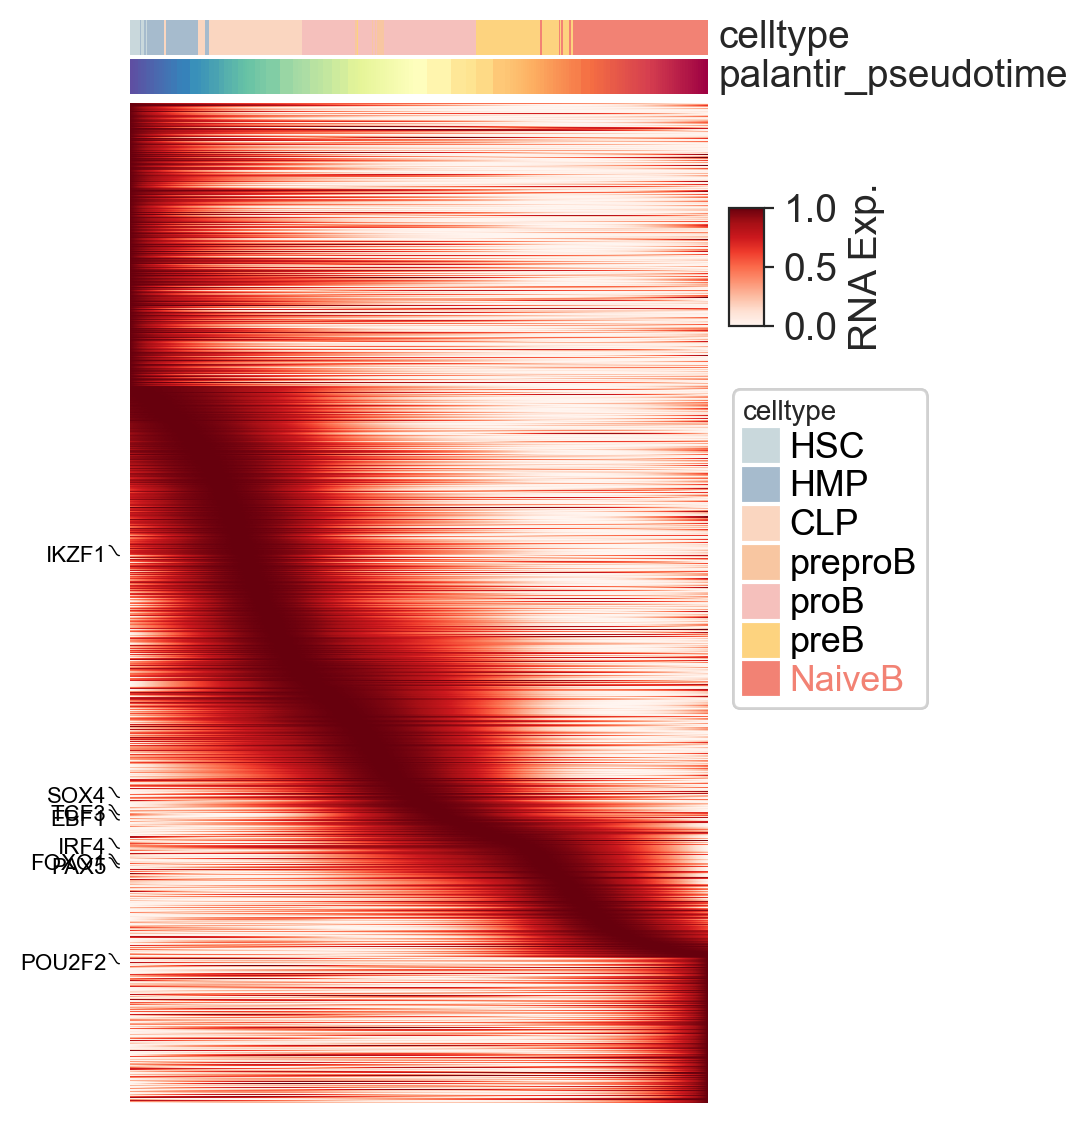

In [57]:
scm.pl.heatmap(
    mdata[mdata["RNA"].obsm["cell_state_masks"]['NaiveB']], 
    var_names=mdata["RNA"][:, mdata["RNA"].var["significant_genes"]].var_names,
    selected_genes=key_TFs,
    modal="RNA",
    layer="log1p_norm",
    sortby="palantir_pseudotime",
    col_annos=['celltype', 'palantir_pseudotime'], 
    smooth_method="gam",
    n_splines=5,
    cmap="Reds",
    label="RNA Exp.",
    figsize=(4, 6)
)

To examine the behavior of individual genes, we can use `scm.pl.trendplot`. This plots the smoothed expression value of selected genes as a function of pseudotime. 

We use the `var_dict` parameter to specify which features to plot: the dictionary keys (e.g., `PAX5`) set the names for the feature, while the values (e.g., `[("RNA", "log1p_norm")]`) define the modality and layer to pull the data from.

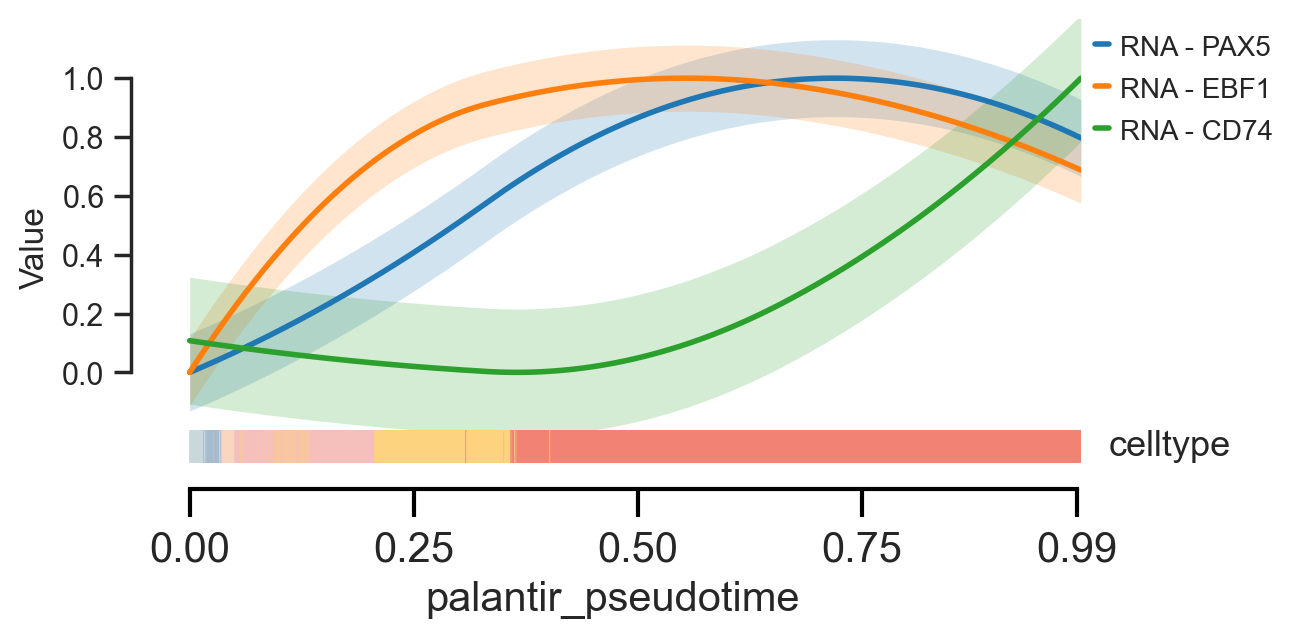

<Axes: xlabel='palantir_pseudotime', ylabel='Value'>

In [43]:
scm.pl.trendplot(
    mdata[mdata["RNA"].obsm["cell_state_masks"]['NaiveB']],
    var_dict={"PAX5": [("RNA", "log1p_norm")], 
              "EBF1": [("RNA", "log1p_norm")], 
              "CD74": [("RNA", "log1p_norm")]},
    normalize = True,
    sortby = "palantir_pseudotime",
    col_color = ["celltype"],
    figsize=(6, 3),
    dpi=100,
    n_splines=5,
    show_tkey=False,
    show_stds=True
)

:::seealso
Several functions in `scMagnify` rely on data smoothing along pseudotime, offering multiple methods inspired by packages like `cellRank` and `palantir`.

The `smooth_method` parameter, available in the functions below, allows you to choose between:
* `'gam'` (Generalized Additive Model)
* `'convolve'` (Moving average convolution)
* `'polyfit'` (Polynomial regression)

For full parameter details, please see the respective API documentation:
* {py:func}`~scmagnify.tl.test_association`
* {py:func}`~scmagnify.pl.heatmap`
* {py:func}`~scmagnify.pl.trendplot`

For a deeper dive and usage examples, refer to the **[Advanced Usage/Data Smoothing](./Advanced Usage/Data Smoothing.md)** guide.
:::

### Save the data

In [44]:
mdata.write(os.path.join(settings.data_dir, "mdata_tcelldep-bm_01.h5mu"))

## Closing matters

### What's next? 

In this tutorial, you learned how to preprocess scRNA-seq data to select cell states and their associated genes. For the next steps, we recommend the following:

- Construct TF binding network with scATACseq and scRNAseq data
- Refer to the {doc}API <scmagnify> to explore the available parameter values that can be used to customize these computations for your data.

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/). You can also contact using chenxufeng2022@sinh.ac.cn.  

### Package versions

In [45]:
import session_info 
session_info.show()